Тестирование различных параметров GAN

1. Создайте генеративную сеть с Dense генератором и дискриминатором. Обучите ее на 3000 эпохах.

2. В новой ячейке запишите latent_dim = 10. В следующей новой ячейке обучите сеть на 3000 эпохах.

3. Теперь поменяйте размер внутреннего пространства генератора с 10 на 1000 (в новой ячейке запишите latent_dim = 1000).  Обучите сеть на 3000 эпохах.

4. В новой ячейке сделайте свёрточный генератор. Запустите сеть со сверточным генератором. Сравните результаты с полносвязным генератором (Достаточно текстом записать выводы). 

5. Сделайте возможность запускать обучение с разными batch_size для генератора и дискриминатора. Для этого в новой ячейке создайте функцию (наподобие GAN_algoritm из практики), которая на вход будет получать разные batch_size. 
Попробуйте запустить обучение сетей с batch_size 128 для дискриминатора и 256 для генератора, сравните результат с равными batch_size по 128.

In [ ]:
# Загрузка библиотек

# Базовые слои keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout

# Еще базовые слои
from keras.layers import BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply, Conv2DTranspose, Concatenate

# Активационная функция
from keras.layers.advanced_activations import LeakyReLU

# Загрузим сверточные слои
from keras.layers.convolutional import UpSampling2D, Conv2D 

# Загрузим форматы моделей
from keras.models import Sequential, Model 

# Загрузим оптимизатор
from tensorflow.keras.optimizers import Adam

# Загрузим модули с датасетами
from keras.datasets import mnist, cifar10, fashion_mnist

# Библиотека для отрисовки графиков
import matplotlib.pyplot as plt 

# Импортируем библиотеку для работы с системой
import sys

# Numpy массивы
import numpy as np

# Модуль отрисовки изображений
from PIL import Image 

# Модуль для загрузки уже готовых моделей
from tensorflow.keras.models import load_model

### Подготовка данных

Для работы используем стандартную базу MNIST. Загрузим все в переменную X_train.

In [ ]:
(x_train, _), (_, _) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


Вот так выглядит картинка (в серой палитре cmap = 'gray'). 

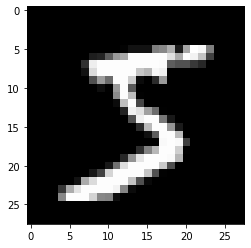

In [ ]:
plt.imshow(x_train[0],cmap='gray')
plt.show()

In [ ]:
# Ваше решение

In [ ]:
# Выводим размерность
print(x_train.shape)

# Нормализуем изображение от [-1,1]
x_train = x_train / 127.5 - 1. 

# Добавляем размерность для x_train ((28,28) => (28,28,1))
x_train = np.expand_dims(x_train, axis=3) 

# Выводим размерность
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
#import sys
import random
# Numpy массивы
#import numpy as np 

# модуль для отрисовки изображения
from PIL import Image 

In [ ]:
# Определяем параметры

img_hieght = 28 # высота изображения
img_width = 28  # ширина изображения
channels = 1    # канал 1 (картинка черно белая)
img_shape = (img_hieght, img_width, channels)

random_vec = 100   # Задаем размер N-мерного вектора
dropout_rait = 0.1 # Задаем размер Dropout
batch_size = 128

In [ ]:
# Функция генератора

def create_generator():

    noise = Input(shape= (random_vec,))             # Входной вектер (шум)
    
    x = Dense(256, activation='relu') (noise)       # Dense-слой
    x = BatchNormalization(momentum=0.8) (x)        # BatchNoramlization-слой
    x = Dense(512, activation='relu') (x)           # Dense-слой
    x = BatchNormalization(momentum=0.8) (x)        # BatchNoramlization-слой
    x = Dense(1024, activation='relu') (x)          # Dense-слой
    x = BatchNormalization(momentum=0.8) (x)        # BatchNoramlization-слой

    # Dense-слой с количеством нейронов, равным произведению ширины на высоту на количество каналов генерируемого изображения
    x = Dense(np.prod(img_shape), activation='tanh') (x) 

    # Reshape-слой для преобразования к размеру картинки
    x = Reshape(img_shape) (x)
    
    generator = Model (noise, x)
    
    return generator     

In [ ]:
# создаем генератор
generator = create_generator() 

# выводим информацию о нем
generator.summary() 

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_16 (Dense)            (None, 256)               256256    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 1024)              5253

In [ ]:
def create_discriminator():
  
  # задаем входной размер картинки дискриминатора
  img = Input(shape=img_shape) 

  # добавляем слои
  x = Flatten(input_shape=img_shape) (img)           # на вход дискриминатора подаем картинку и вытягиваем ее в вектор
  x = Dense(512, activation='relu') (x)
  x = Dropout(dropout_rait) (x)
  x = Dense(756, activation='relu') (x)
  x = Dropout(dropout_rait) (x)
  x = Dense(256, activation = 'relu') (x)
  x = Dropout(dropout_rait) (x)
  x = Dense(1, activation='sigmoid') (x)  

  # собираем дискриминатор
  discriminator = Model(img, x) 
  
  # компилируем
  discriminator.compile(loss='binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics=['accuracy'])

  discriminator.trainable = False # По умолчанию дискриминатор заморожен, т.е. его веса не будут меняться в процессе обучения
  
  return discriminator

In [ ]:
discriminator = create_discriminator()
discriminator.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               401920    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 756)               387828    
                                                                 
 dropout_7 (Dropout)         (None, 756)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               193

In [ ]:
def sample_images(epoch, gen):
    # Задание параметров полотна (ширина и высота)
    r, c = 5, 5               

    # Генерация вектора-шума, который будет подаваться на вход генератору
    noise = np.random.normal(0, 1, (r * c, random_vec))

    # Генерация изображений
    gen_imgs = gen.predict(noise) # Предиктим картинку с помощью входной переменной gen
  
    # Вывод сгенерированных изображений    
    fig, axs = plt.subplots(r, c, figsize = (r*2,c*2)) # Создаем окно вывода r на c (5 на 5) ячеек
    idx = 0 # Порядковый номер картинки
    for i in range(r): 
        for j in range(c):
            axs[i, j].imshow(gen_imgs[idx, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            idx += 1
    plt.show() # Рисуем сгенерированные изображения
    plt.close() # Завершаем работу с plt

In [ ]:


def GAN_algoritm (generator, discriminator, epochs=30000, batch_size=128,batch_size_d=128,DiskrTrainOnEpoch=1):
    # Создание массивов меток для дискриминатора
    true_labels = np.ones((batch_size, 1)) 
    generated_labels = np.zeros((batch_size, 1)) 

    true_labels_d = np.ones((batch_size_d, 1)) 
    generated_labels_d = np.zeros((batch_size_d, 1)) 

    # Создание полной модели GAN (включающую генератор и дискриминатор)
    noise = Input (shape=(random_vec,))
    generate_img = generator(noise)
    discr_result = discriminator(generate_img) 

    GAN = Model(noise, discr_result) # Собираем модель GAN в которой обе модели G и D в входят как слои. На вход GAN подаем вектор, на выходе оценка вероятности
    GAN.compile(loss='binary_crossentropy', optimizer = Adam(0.0002, 0.5))

    view_interval = 500 # интервал через который будем смотреть что получается
  
    d_loss_list = [] # лист значений ошибки дискриминатора
    g_loss_list = [] # лист значений ошибки генератора
    d_acc_list = [] # лист значений ошибки точность модели
  
    for epoch in range(epochs):
        # Получение случайных изображений из набора MNIST        
        for D_epoch in range(DiskrTrainOnEpoch):
          imgs = np.array(random.choices(x_train, k=batch_size_d))
          
          # Генерация вектора-шума, который подается на вход генератора
          noise = np.random.normal(0, 1, (batch_size_d, random_vec)) # записываем в переменную noise вектора, длинной random_vec в количестве batch_size

          # Генерация изображения с помощью генератора
          gen_imgs = generator.predict(noise)

          # Обучение дискриминатора
          d_loss_real = discriminator.train_on_batch(imgs, true_labels_d)
          d_loss_gen = discriminator.train_on_batch(gen_imgs, generated_labels_d)
          
          d_loss = 0.5* np.add(d_loss_real,d_loss_gen)

        noise = np.random.normal(0, 1, (batch_size, random_vec)) # записываем в переменную noise вектора, длинной random_vec в количестве batch_size
        # Обучение генератора
        g_loss = GAN.train_on_batch(noise,true_labels)
      
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)
        d_acc_list.append(100*d_loss[1])
    
        # Проверка эпох для вывода картинок
        if ((epoch % view_interval == 0) | (epoch == epochs-1)):
            sample_images(epoch, generator)
            print ('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # выводим номер эпохи и значения ошибок


    plt.plot(d_loss_list, label="Ошибка дискриминатора")
    plt.plot(g_loss_list, label="Ошибка генератора")
    plt.legend()
    plt.show()
    plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
    plt.legend()
    plt.show()   

In [ ]:
latent_dim=10
random_vec = latent_dim   # Задаем размер N-мерного вектора

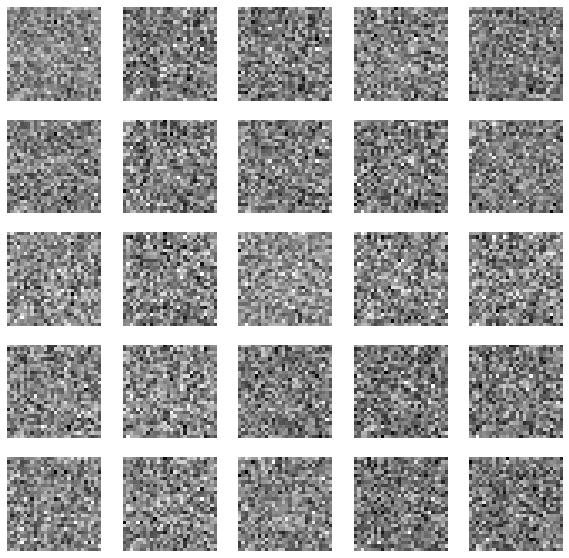

0 [D loss: 0.778141, acc.: 13.67%] [G loss: 0.490367]


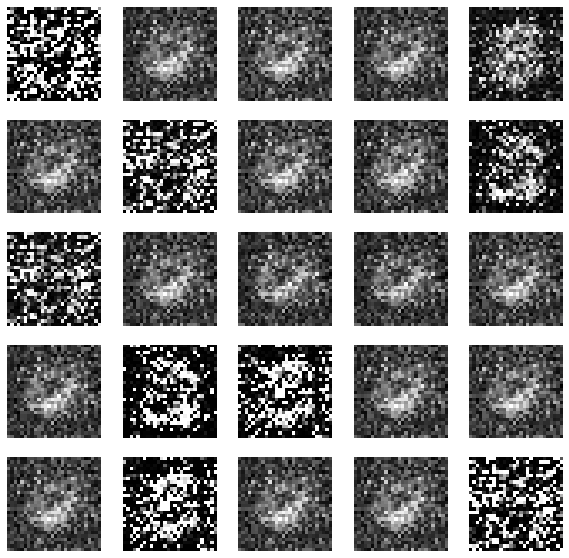

500 [D loss: 0.071084, acc.: 98.44%] [G loss: 5.594793]


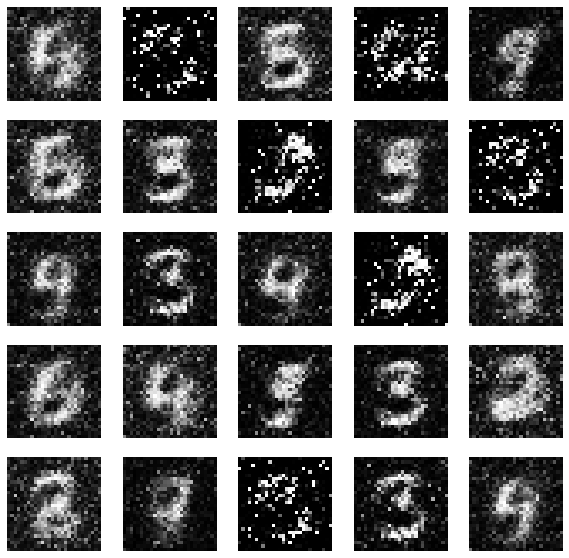

1000 [D loss: 0.528910, acc.: 71.48%] [G loss: 1.881572]


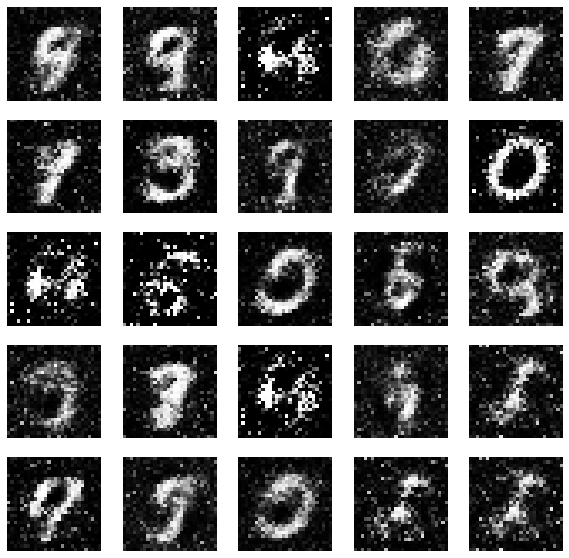

1500 [D loss: 0.599501, acc.: 67.19%] [G loss: 1.393920]


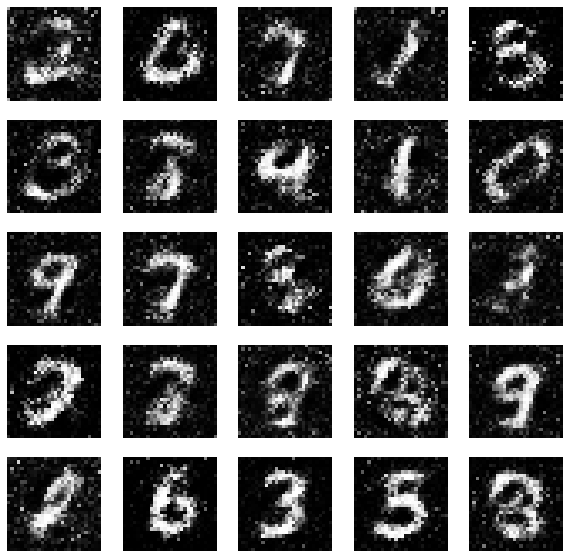

2000 [D loss: 0.607584, acc.: 67.58%] [G loss: 1.129306]


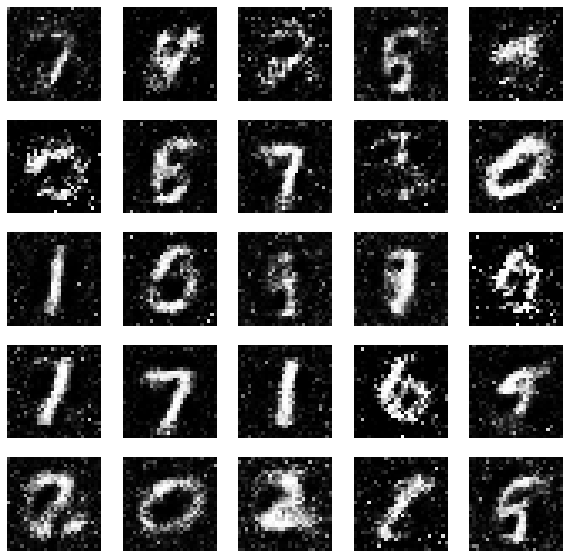

2500 [D loss: 0.611548, acc.: 66.41%] [G loss: 1.005960]


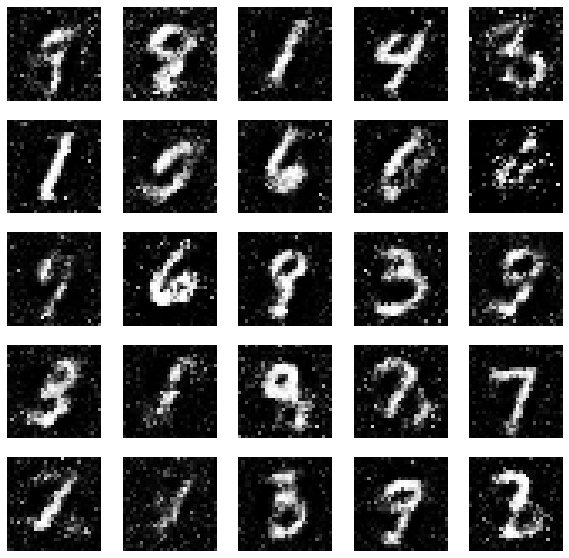

2999 [D loss: 0.659260, acc.: 58.98%] [G loss: 0.993199]


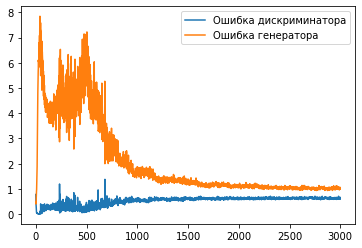

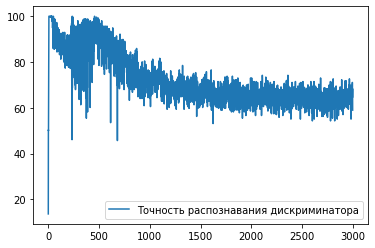

In [ ]:
GAN_algoritm (generator, discriminator, 3000, batch_size=128,batch_size_d=128) 

In [ ]:
latent_dim=1000
random_vec = latent_dim   # Задаем размер N-мерного вектора

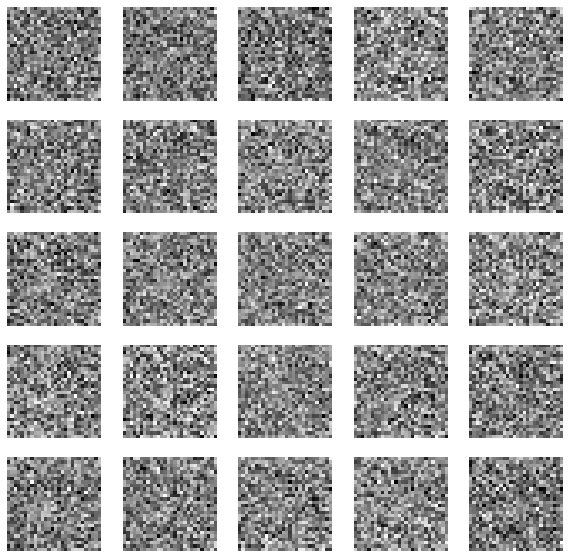

0 [D loss: 0.698387, acc.: 43.36%] [G loss: 0.482439]


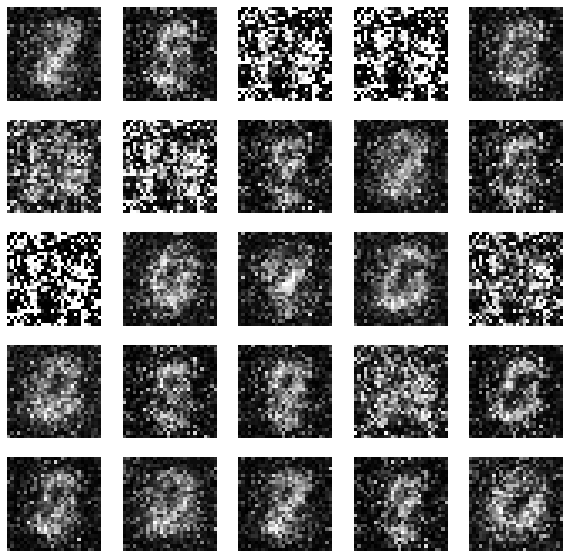

500 [D loss: 0.361953, acc.: 83.98%] [G loss: 3.423065]


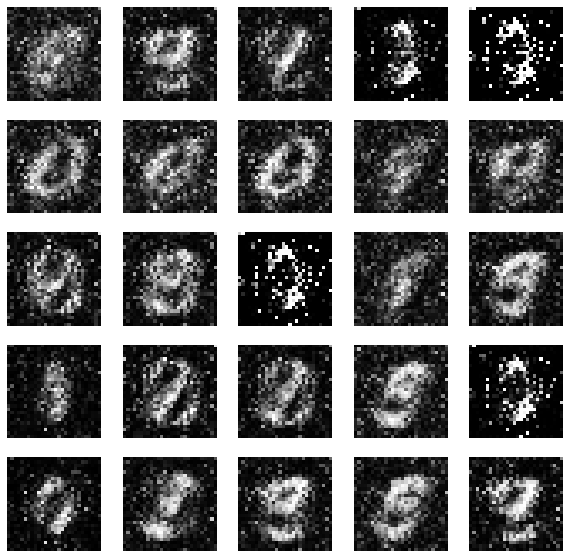

1000 [D loss: 0.481291, acc.: 78.91%] [G loss: 1.889396]


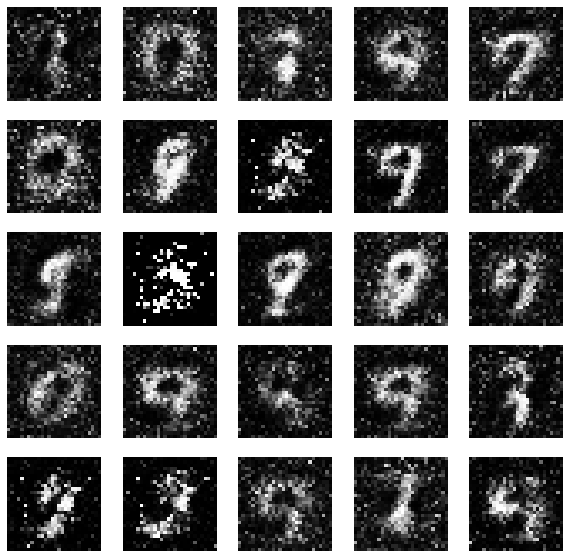

1500 [D loss: 0.468218, acc.: 75.78%] [G loss: 1.874596]


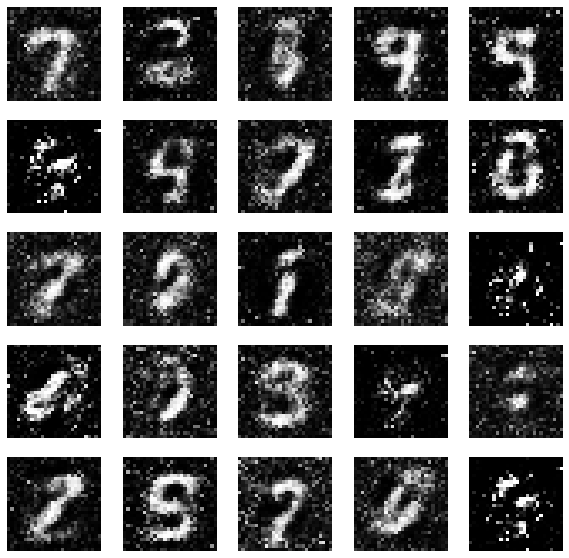

2000 [D loss: 0.583173, acc.: 68.75%] [G loss: 1.556712]


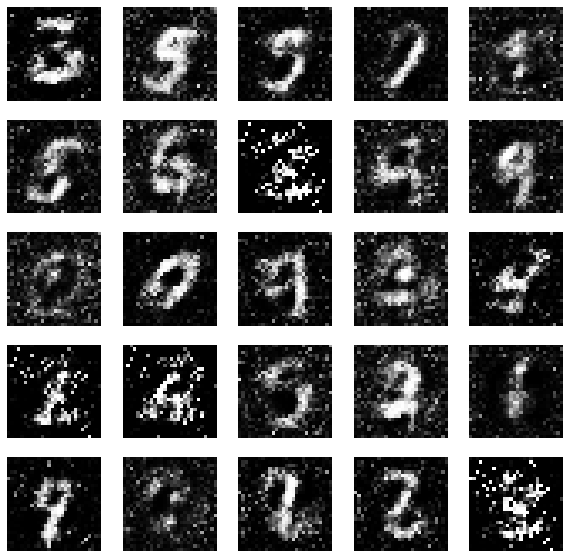

2500 [D loss: 0.553058, acc.: 70.70%] [G loss: 1.540767]


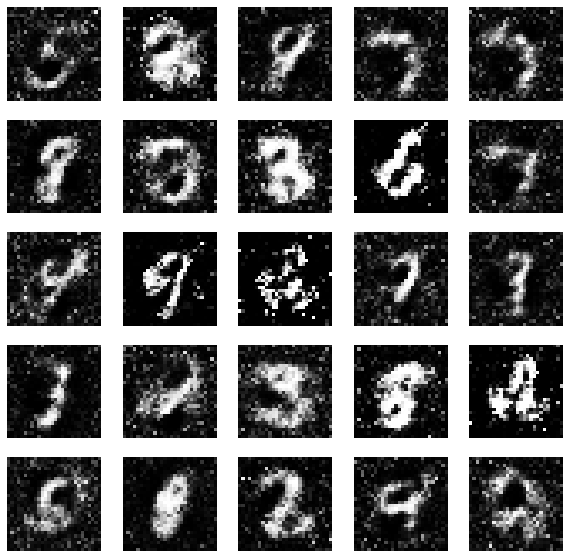

2999 [D loss: 0.557721, acc.: 70.70%] [G loss: 1.642520]


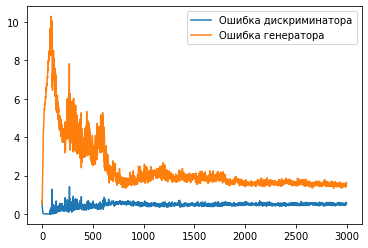

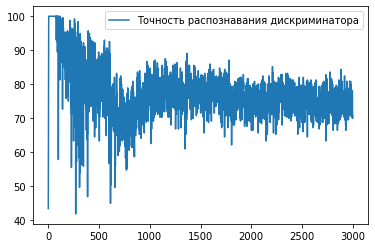

In [ ]:
GAN_algoritm (generator, discriminator, 3000, batch_size=128,batch_size_d=128) 

In [ ]:
def create_conv_generator():
  
  noise = Input(shape=(random_vec,)) # Создаем вход размером random_vec - вектор со случайным номрмальным распределением - шум
  
  gen = Dense(1024)(noise) # Подаем шум на полносвязный слой, размер слоя выбран так, что бы его можно было преобразовать в удобный для нас размер
  gen = LeakyReLU(alpha=0.2) (gen) # Применяем активационную ф-ю LeakyReLU с параметром наклона 0.2
  gen = BatchNormalization()(gen) # Добавляем слой нормализации
  gen = Dropout(dropout_rait)(gen)
  gen = Reshape((32,32,1))(gen) # Преобразуем входящий вектор в тензор 1024 --> 32 * 32 * 1 
  gen = Conv2D(16,(3,3), padding='same')(gen) # Применяем сверточный слой 
  gen = LeakyReLU(alpha=0.2) (gen)
  gen = BatchNormalization()(gen) 
  gen = Dense(256) (gen)
  gen = LeakyReLU(alpha=0.2) (gen)
  gen = BatchNormalization()(gen)   
  gen = Conv2D(22,(3,3), padding='same')(gen) # Применяем сверточный слой 
  gen = LeakyReLU(alpha=0.2) (gen)
  gen = BatchNormalization(momentum=0.8)(gen) 
  gen = Flatten()(gen) # Вытягиваем тезор в вектор 
  gen = Dense(784, activation='tanh')(gen) 
  img = Reshape((28,28,1))(gen)

  model = Model(noise,img)
  return model

In [ ]:
# создаем генератор
conv_gen = create_conv_generator() 

# выводем информацию о нейронной сети
conv_gen.summary() 

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1025024   
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 1024)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 reshape_4 (Reshape)         (None, 32, 32, 1)         0         
                                                           

In [ ]:
def create_conv_discriminator(): # Функция создания сверточного дискрминатора
  
  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)

  conv_disc = Conv2D(4, (3,3), padding="same")(img) # Создаем слой  Conv2D (размерность входных данных (img_shape), ядро свертки = 2, окно свертки = (3,3))
  conv_disc = LeakyReLU(alpha=0.2)(conv_disc) # Применяем активационную ф-ю LeakyReLU с параметром наклона 0.2
  conv_disc = Flatten()(conv_disc) # Добавляем слой Flatten ()
  conv_disc = Dense(512)(conv_disc) # Добавляем Dense-слой на 512 нейронов
  conv_disc = LeakyReLU(alpha=0.2)(conv_disc) # Добавляем слой активационной функции с параметром 0.2
  classifier = Dense(1, activation='sigmoid')(conv_disc) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  discriminator_conv = Model(img, classifier) # Создаем модель discriminator_conv (входные данные: img, выходные данные: classifier)

  # Компилируем модель дискриманотра
  discriminator_conv.compile(loss='binary_crossentropy', # Компилируем модель, выбираем ф-ю ошибки бинраная кроссэнтропия
              optimizer=Adam(0.0002, 0.5), # Выбираем оптимизатор Адам с рекомендованными параметрами lr=0.0002, уменьшаем импульс β1 с 0.9 (по умолчанию)
                                           # до 0.5 что бы уменьшить колебания и увеличить стабильность обучения
              metrics=['accuracy'])
 
  discriminator_conv.trainable = False  # Замораживаем обучение дискриматора 
 
  return discriminator_conv # Функция возвращает discriminator_conv

In [ ]:
# создаем дискриминатор
conv_disc = create_conv_discriminator() 

# выводем информацию о нейронной сети
conv_disc.summary() 

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 4)         40        
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 28, 28, 4)         0         
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1606144   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 513

In [ ]:
latent_dim=10
random_vec = latent_dim   # Задаем размер N-мерного вектора
dropout_rait=0.4

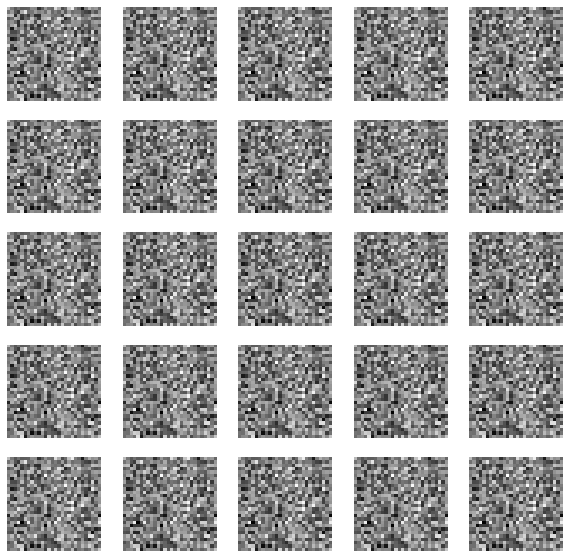

0 [D loss: 0.647990, acc.: 50.00%] [G loss: 0.065369]


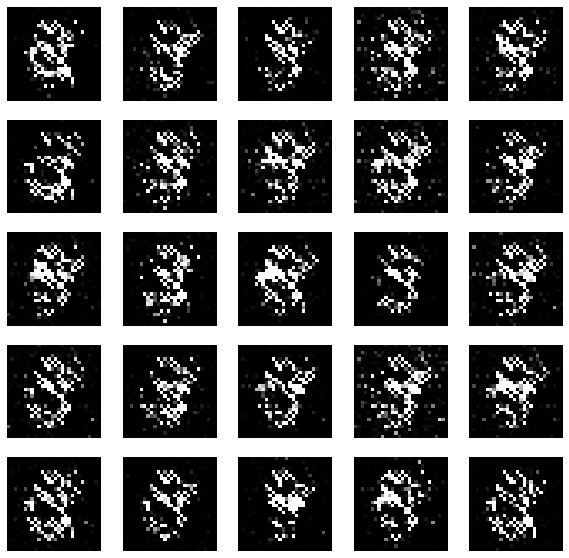

500 [D loss: 0.175858, acc.: 95.31%] [G loss: 0.755303]


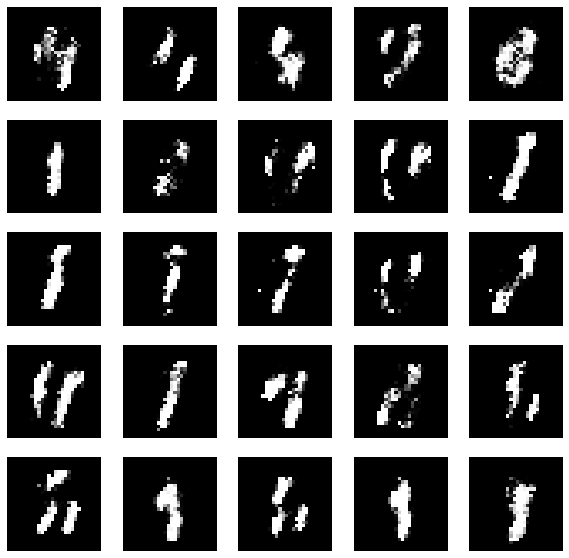

1000 [D loss: 0.278037, acc.: 91.02%] [G loss: 2.510599]


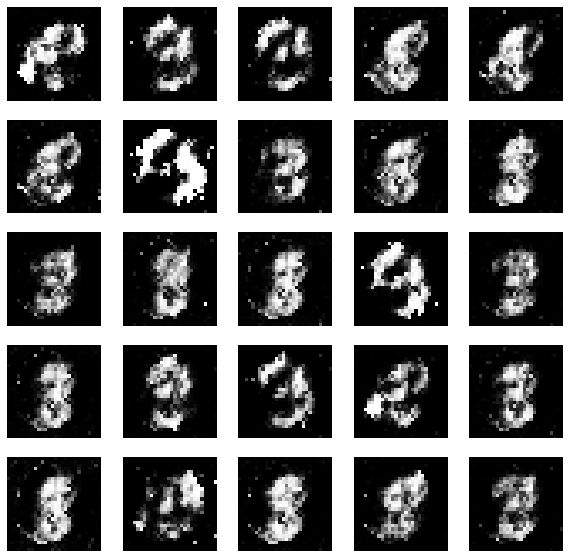

1500 [D loss: 0.847761, acc.: 50.39%] [G loss: 2.505512]


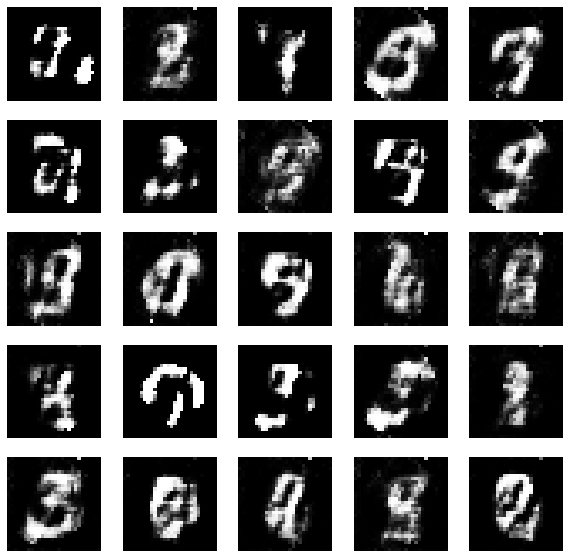

2000 [D loss: 0.672931, acc.: 58.98%] [G loss: 0.868779]


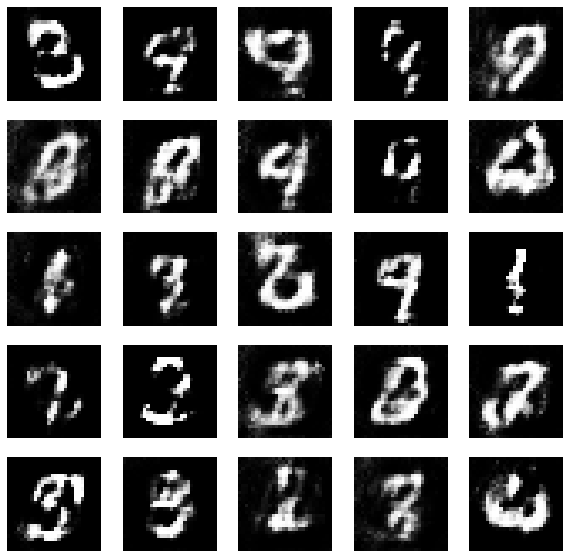

2500 [D loss: 0.652791, acc.: 66.80%] [G loss: 0.874045]


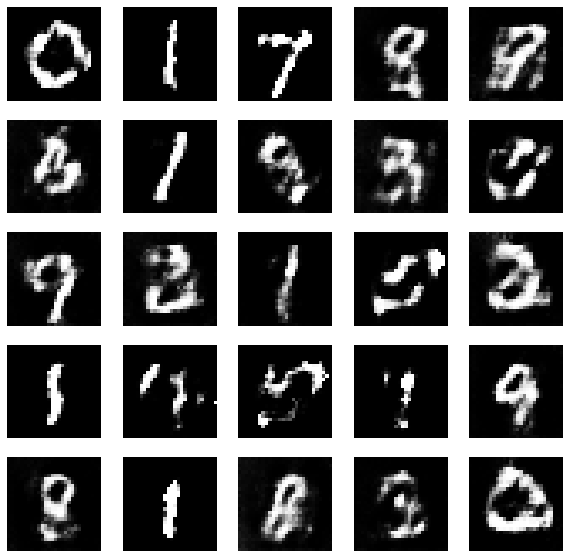

2999 [D loss: 0.648814, acc.: 63.28%] [G loss: 0.890120]


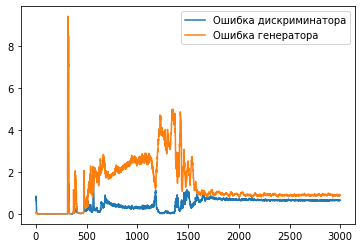

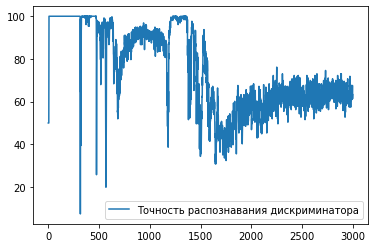

In [ ]:
GAN_algoritm (conv_gen,conv_disc,3000,batch_size=128,batch_size_d=128) 

In [ ]:
latent_dim=1000
random_vec = latent_dim   # Задаем размер N-мерного вектора
dropout_rait=0.4

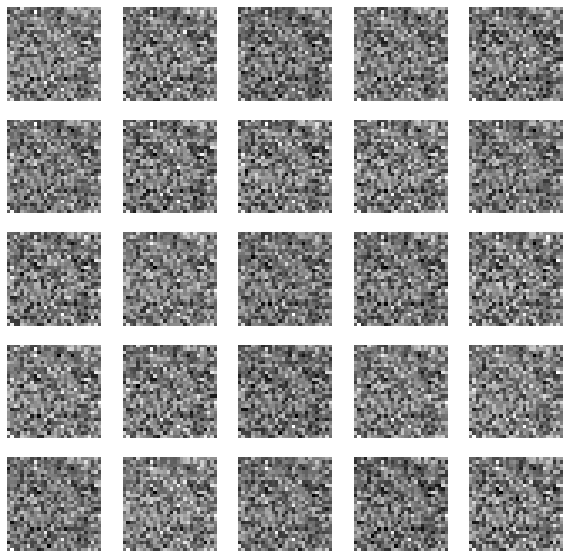

0 [D loss: 0.476376, acc.: 50.00%] [G loss: 0.285736]


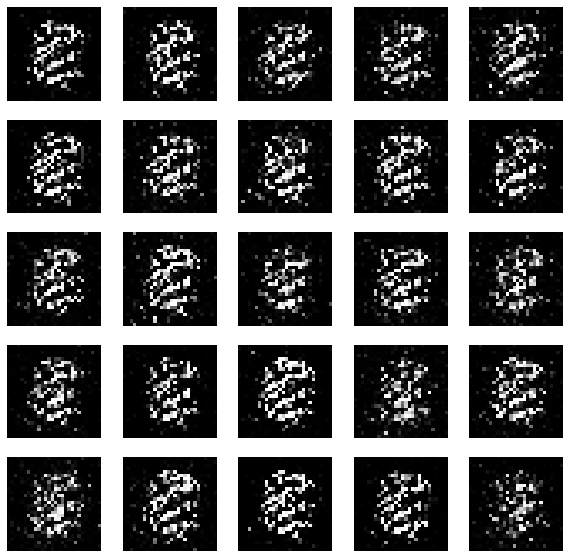

500 [D loss: 0.620882, acc.: 64.84%] [G loss: 1.290365]


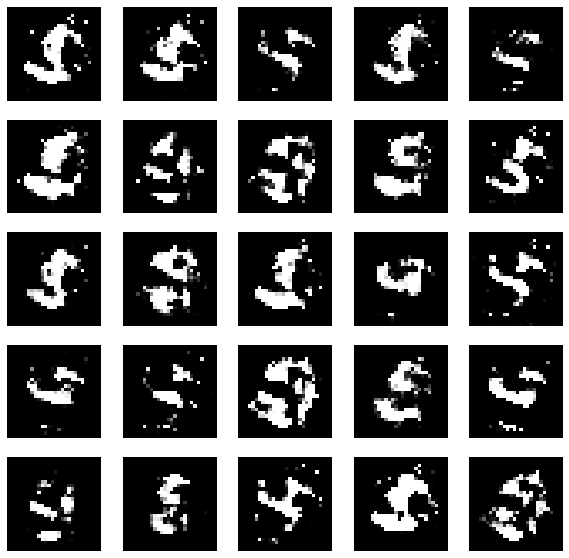

1000 [D loss: 0.610017, acc.: 68.75%] [G loss: 2.062614]


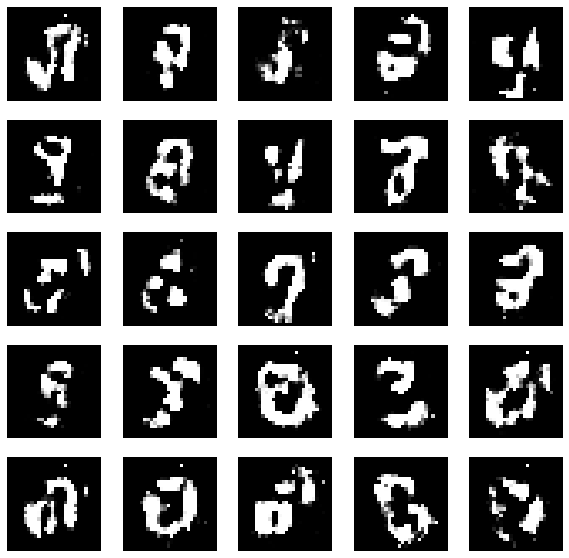

1500 [D loss: 0.623011, acc.: 67.97%] [G loss: 1.466736]


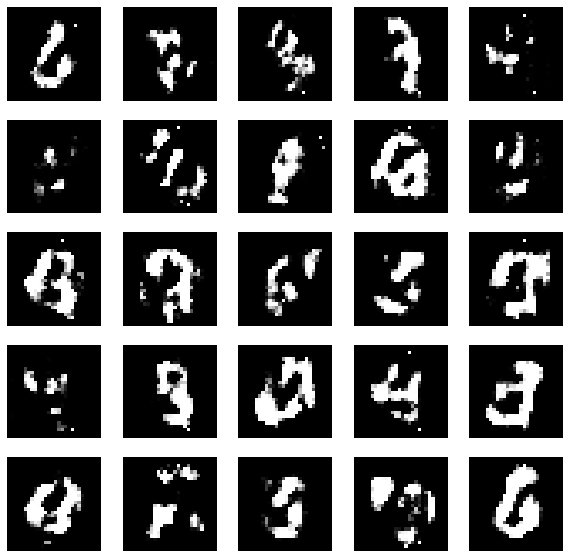

2000 [D loss: 0.554062, acc.: 75.78%] [G loss: 1.627459]


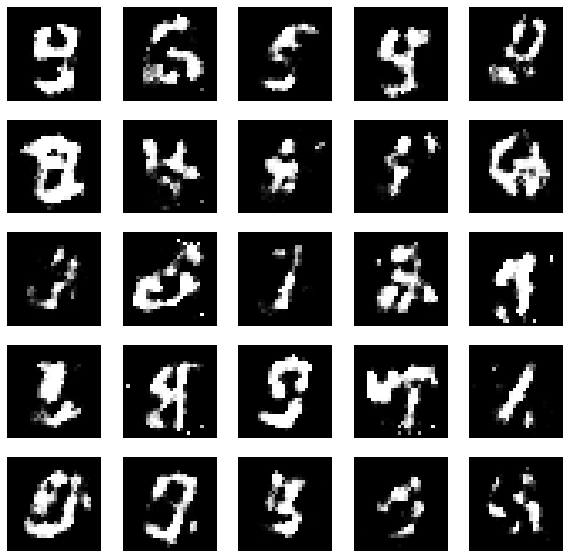

2500 [D loss: 0.595751, acc.: 70.31%] [G loss: 1.688651]


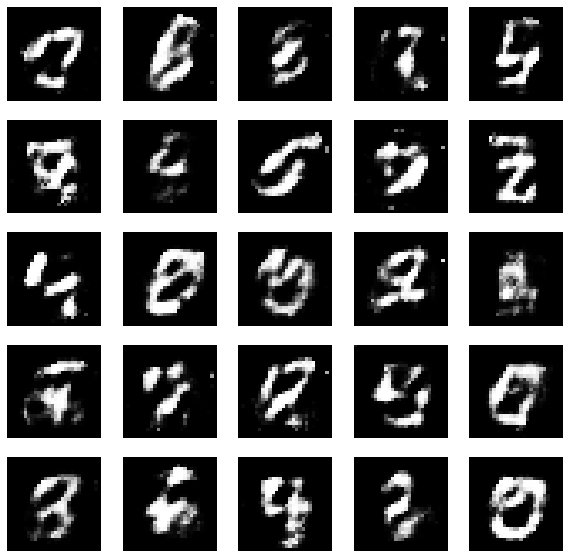

2999 [D loss: 0.771804, acc.: 49.61%] [G loss: 1.297281]


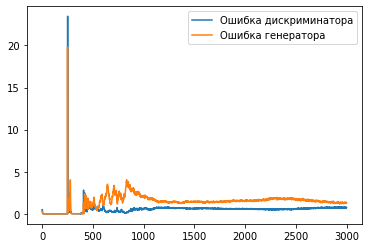

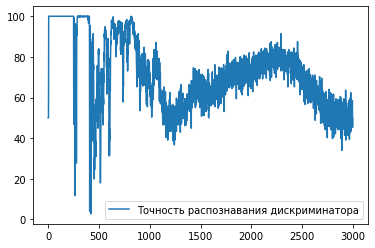

In [ ]:
GAN_algoritm (conv_gen,conv_disc,3000,batch_size=128,batch_size_d=128) 

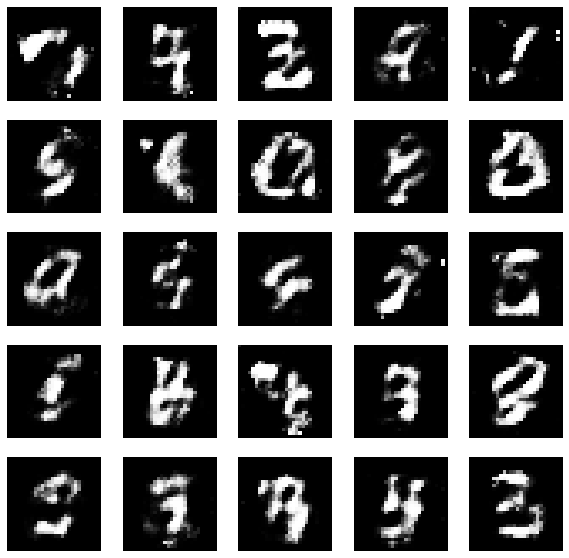

0 [D loss: 0.715104, acc.: 51.95%] [G loss: 1.313398]


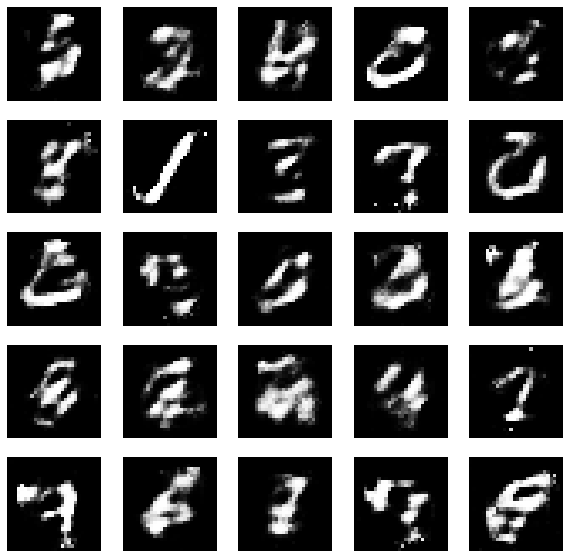

500 [D loss: 0.668253, acc.: 60.55%] [G loss: 1.227408]


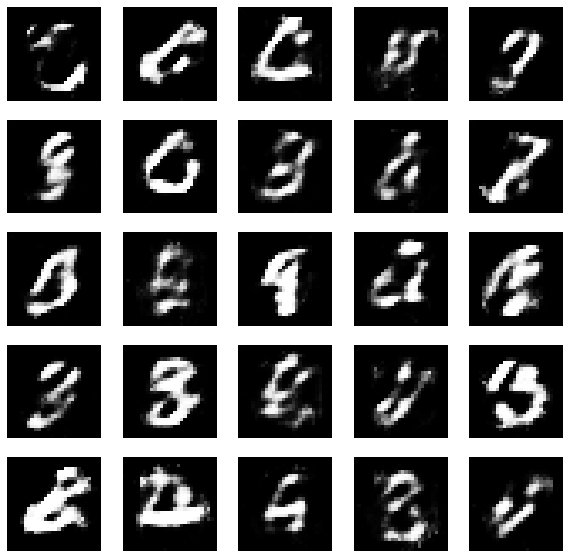

1000 [D loss: 0.719739, acc.: 55.47%] [G loss: 1.130456]


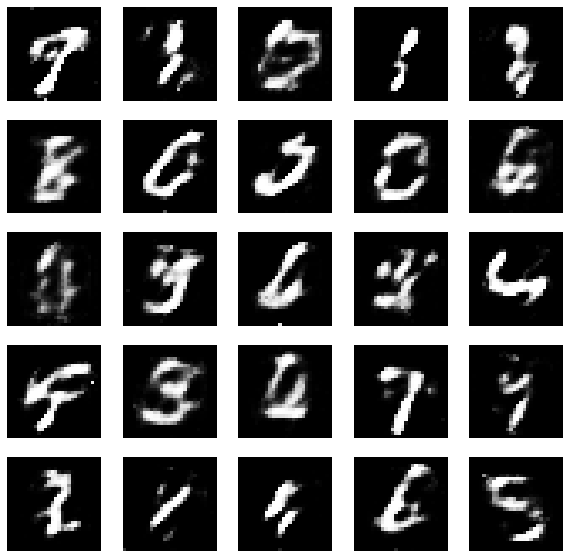

1500 [D loss: 0.700092, acc.: 53.52%] [G loss: 1.156849]


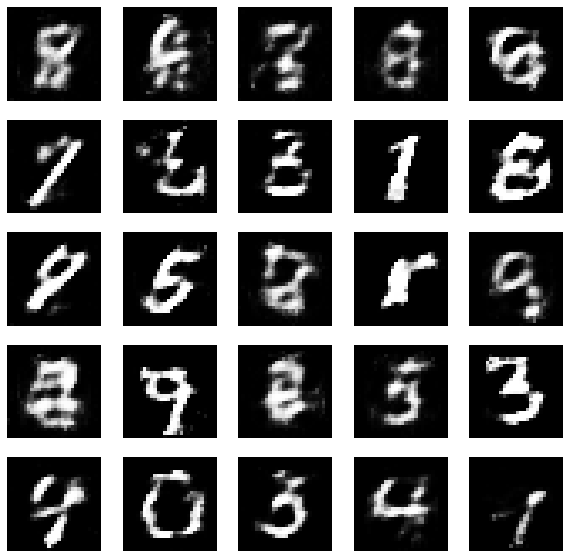

2000 [D loss: 0.692437, acc.: 52.34%] [G loss: 1.056252]


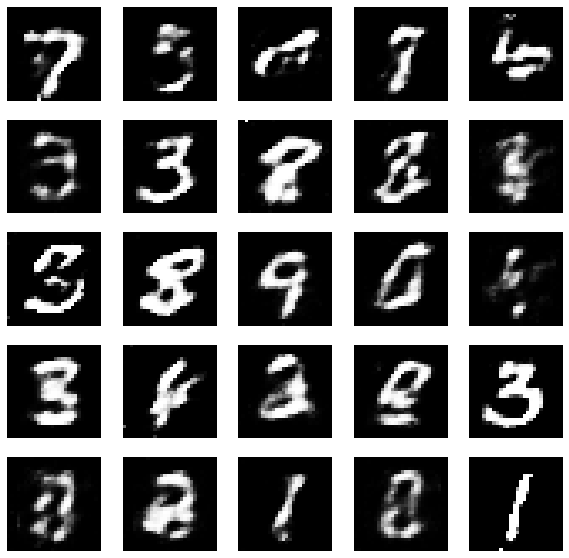

2500 [D loss: 0.636272, acc.: 63.28%] [G loss: 0.931531]


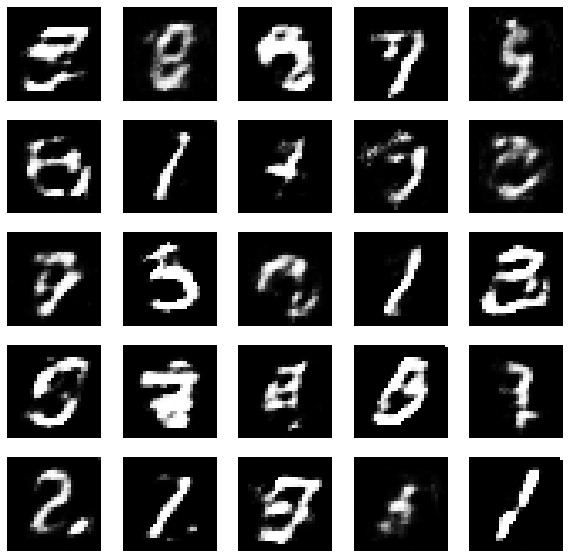

3000 [D loss: 0.637350, acc.: 55.47%] [G loss: 1.098558]


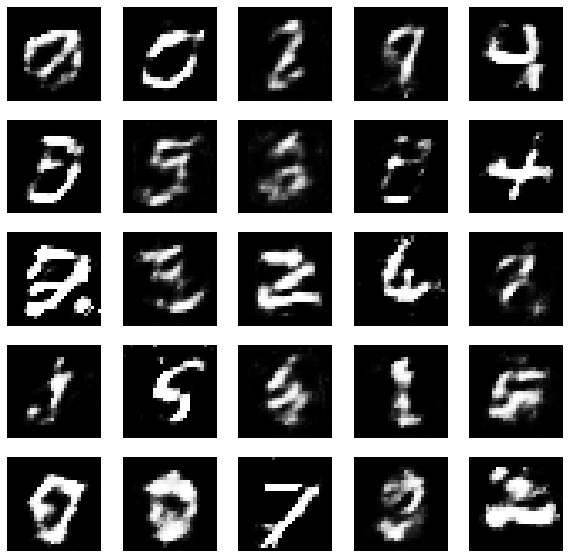

3500 [D loss: 0.649555, acc.: 58.98%] [G loss: 1.136528]


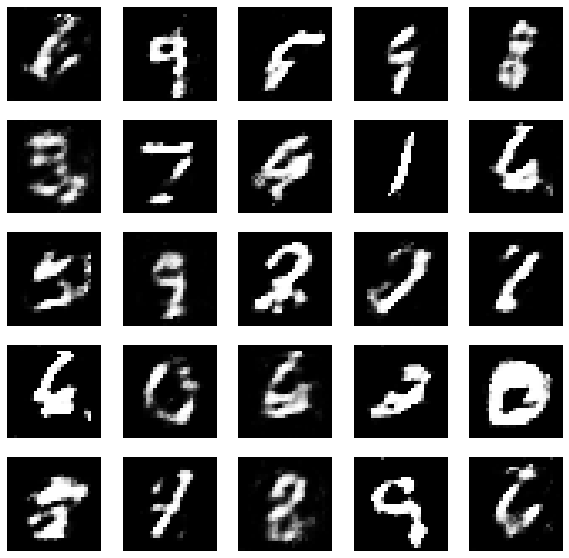

4000 [D loss: 0.676102, acc.: 58.20%] [G loss: 1.198489]


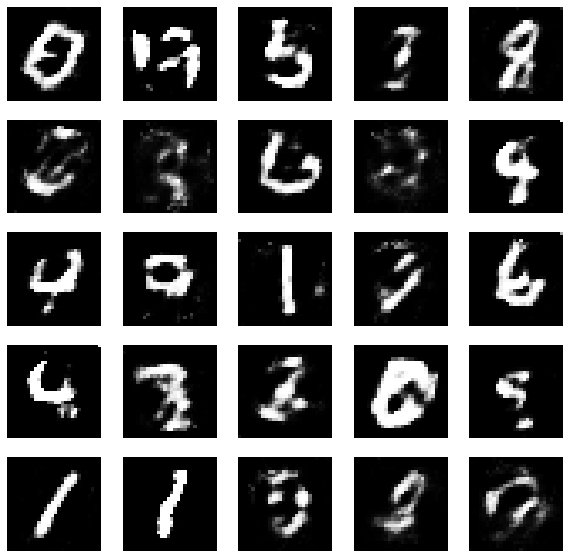

4500 [D loss: 0.599992, acc.: 64.06%] [G loss: 1.005779]


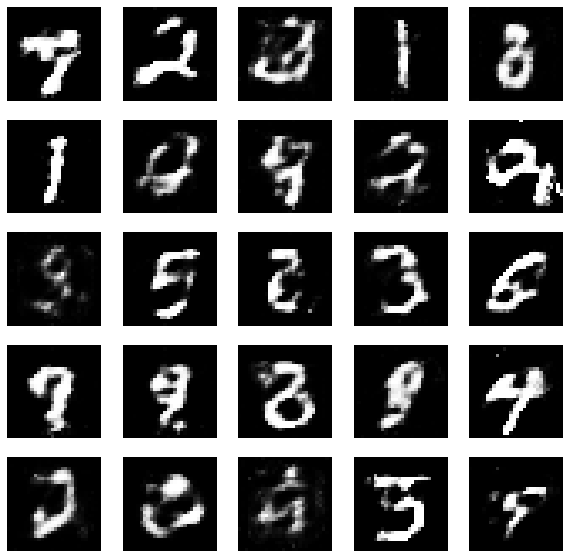

5000 [D loss: 0.573972, acc.: 64.84%] [G loss: 1.087999]


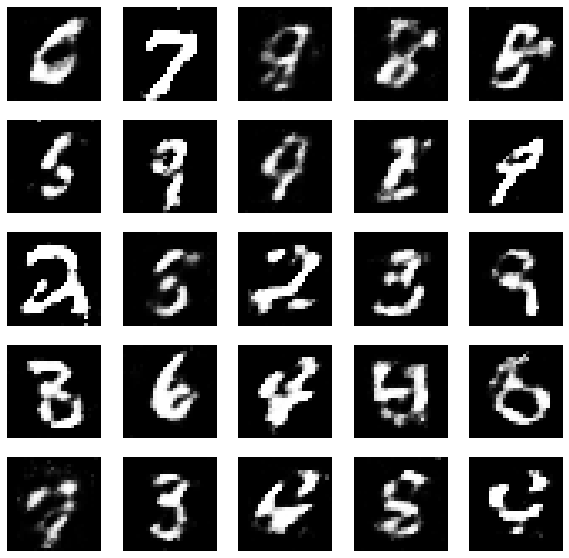

5500 [D loss: 0.551304, acc.: 69.92%] [G loss: 1.222246]


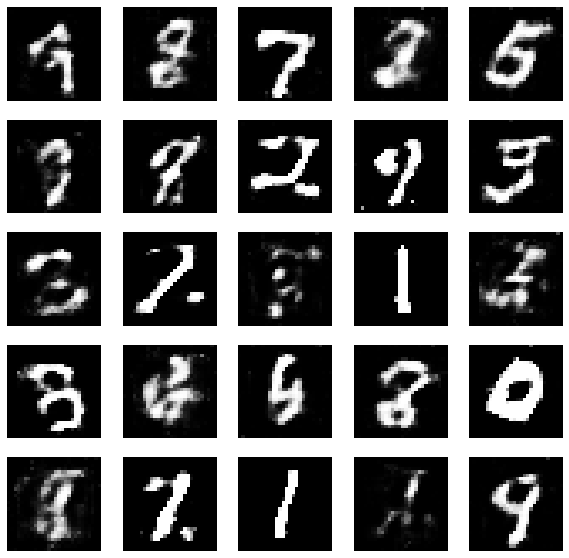

5999 [D loss: 0.485543, acc.: 75.78%] [G loss: 1.054197]


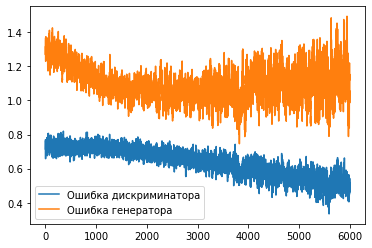

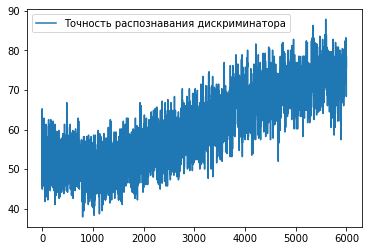

In [ ]:
GAN_algoritm (conv_gen,conv_disc,6000,batch_size=128,batch_size_d=128) 

Разные batch size для генератора и дискриминатора

In [ ]:
latent_dim=1000
random_vec = latent_dim   # Задаем размер N-мерного вектора

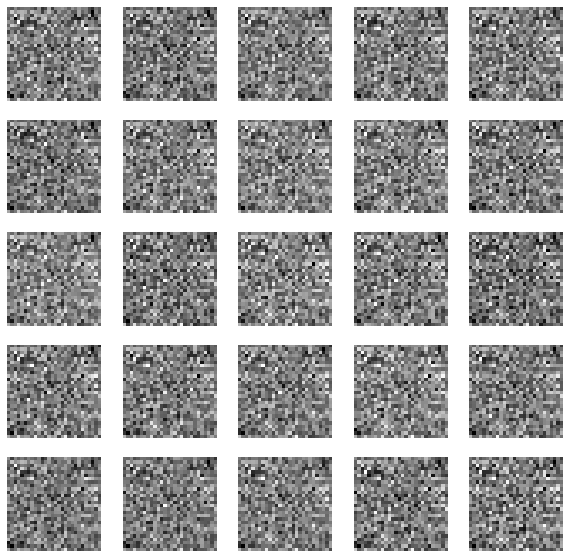

0 [D loss: 0.451430, acc.: 71.88%] [G loss: 14.734172]


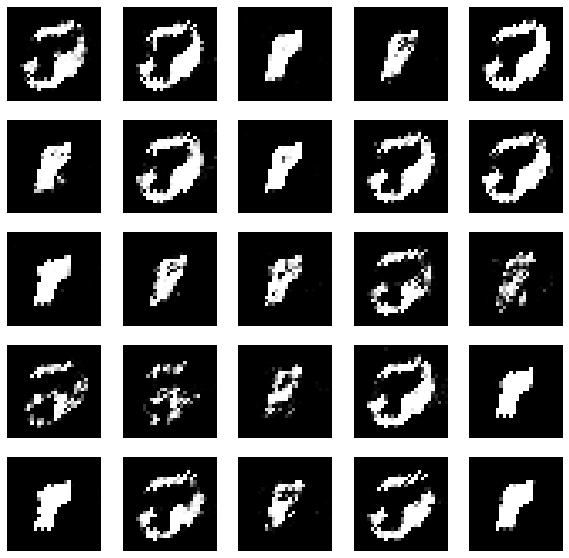

500 [D loss: 0.406706, acc.: 83.98%] [G loss: 2.994413]


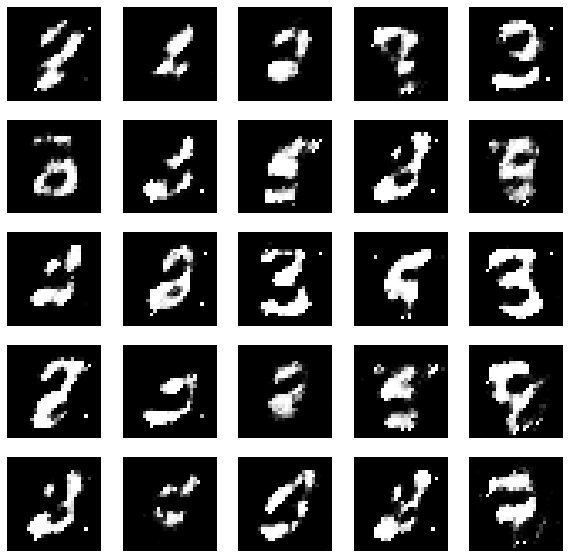

1000 [D loss: 0.606469, acc.: 69.53%] [G loss: 1.555925]


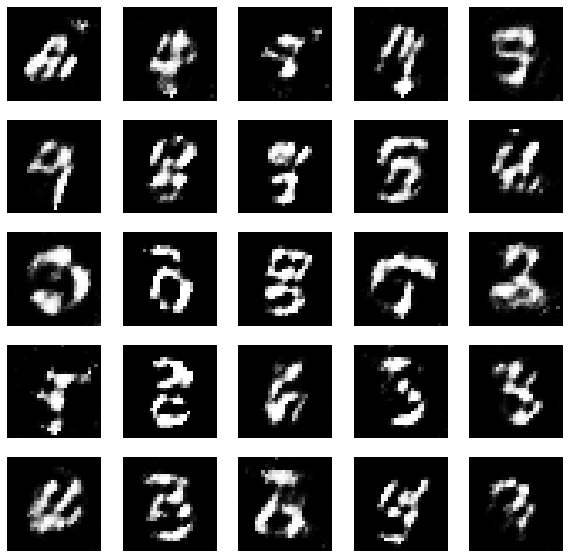

1500 [D loss: 0.716546, acc.: 53.52%] [G loss: 0.919077]


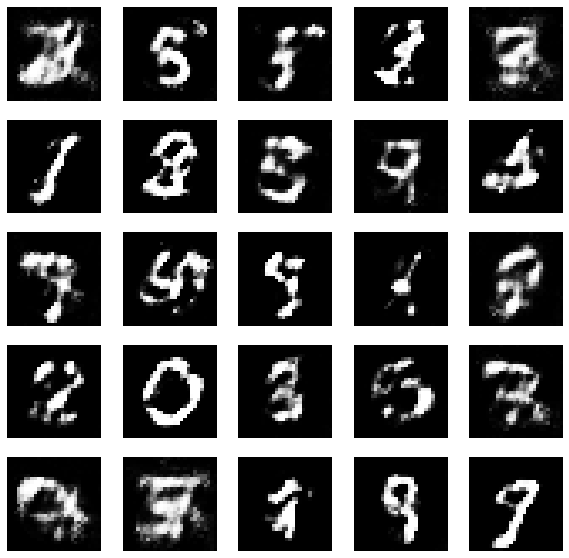

2000 [D loss: 0.673842, acc.: 55.47%] [G loss: 0.848827]


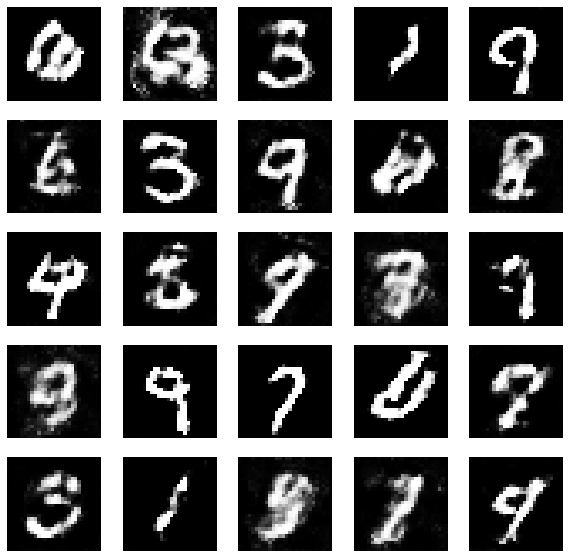

2500 [D loss: 0.665956, acc.: 58.59%] [G loss: 0.916595]


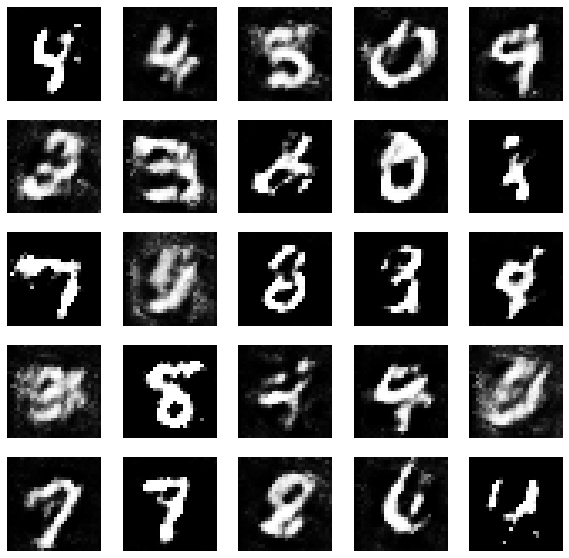

2999 [D loss: 0.613805, acc.: 67.19%] [G loss: 0.999957]


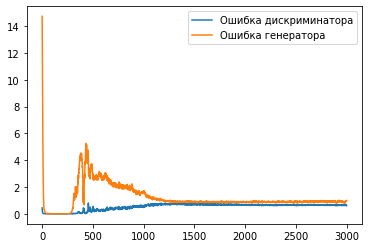

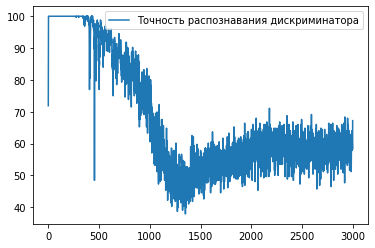

In [ ]:
GAN_algoritm (conv_gen,conv_disc,3000,batch_size=256,batch_size_d=128,DiskrTrainOnEpoch=1) 

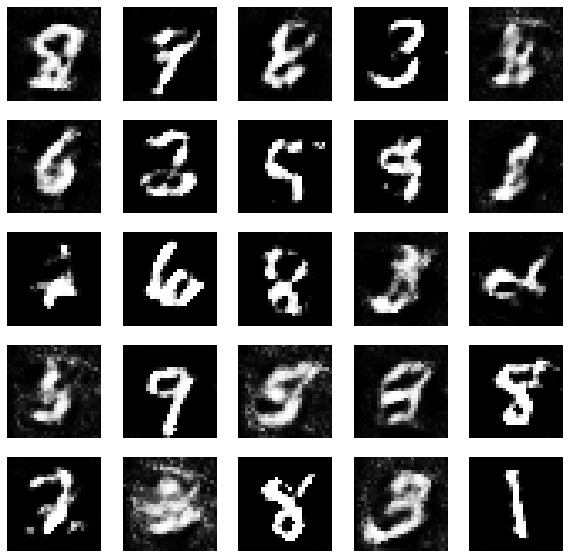

0 [D loss: 0.651866, acc.: 57.03%] [G loss: 0.845951]


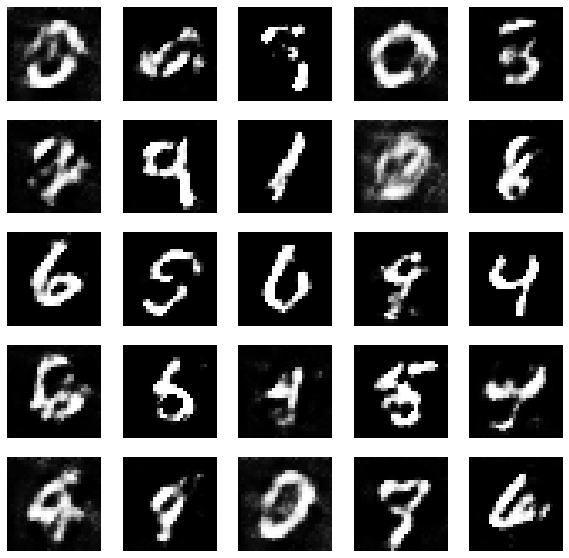

500 [D loss: 0.612816, acc.: 65.23%] [G loss: 0.894583]


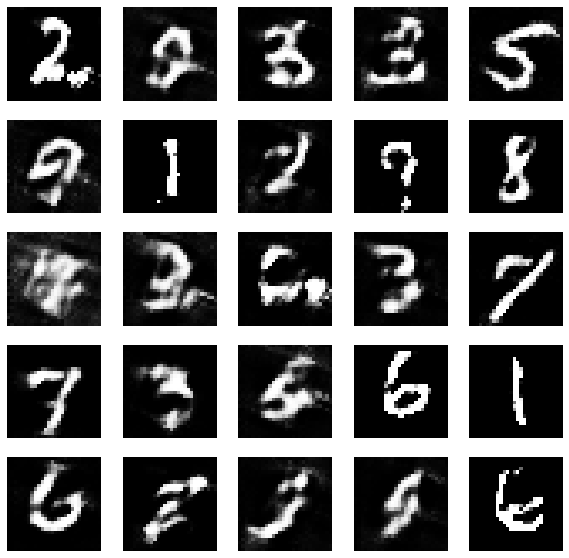

1000 [D loss: 0.648081, acc.: 62.11%] [G loss: 1.003345]


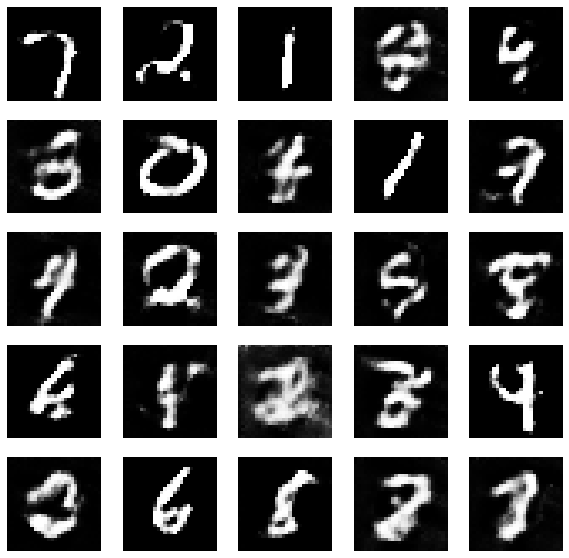

1500 [D loss: 0.681322, acc.: 57.42%] [G loss: 0.998002]


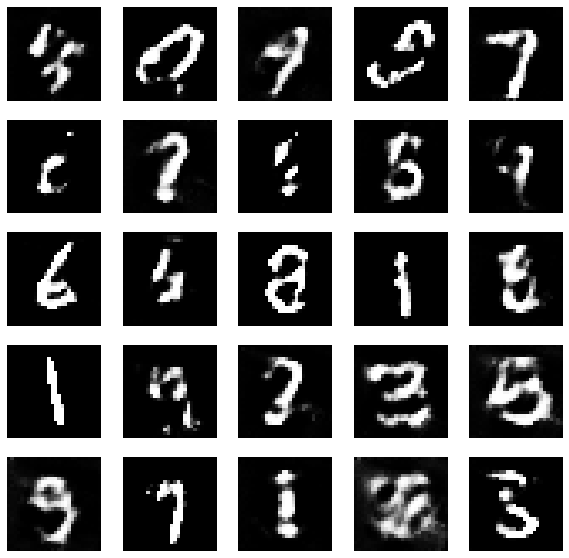

2000 [D loss: 0.632285, acc.: 67.58%] [G loss: 1.154247]


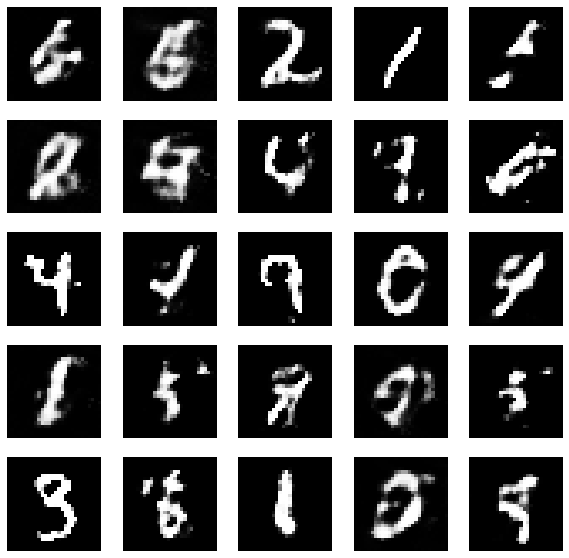

2500 [D loss: 0.574678, acc.: 75.39%] [G loss: 1.266241]


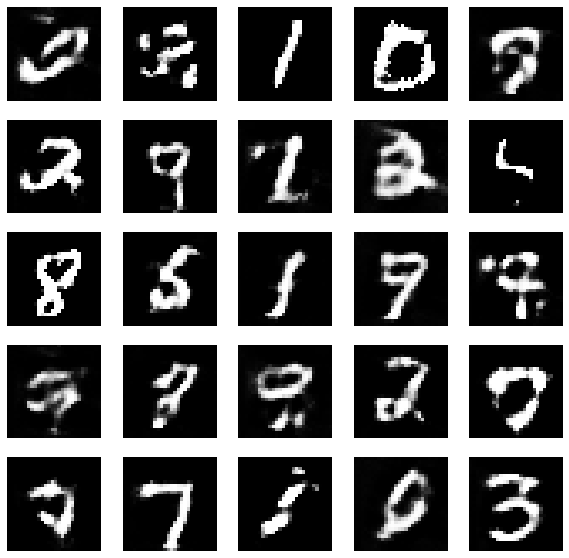

3000 [D loss: 0.631152, acc.: 68.36%] [G loss: 1.280523]


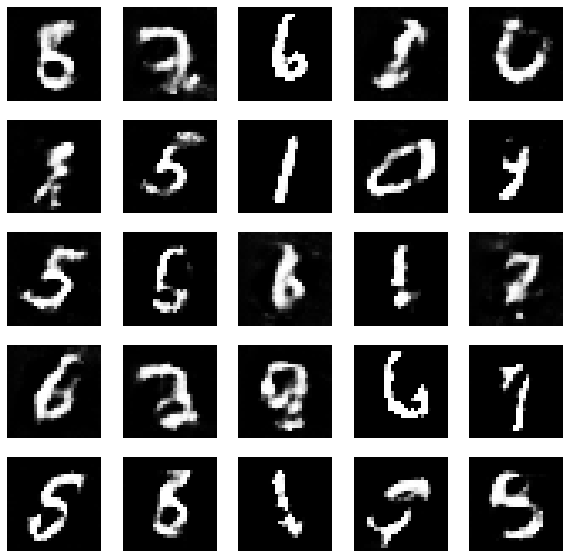

3500 [D loss: 0.543282, acc.: 73.44%] [G loss: 1.531687]


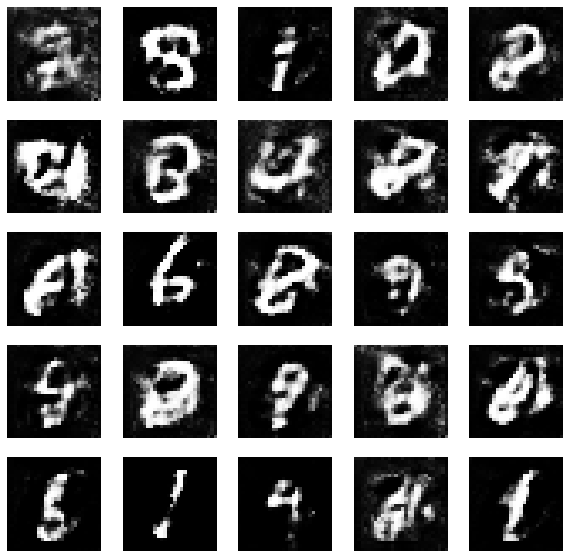

4000 [D loss: 0.206366, acc.: 94.92%] [G loss: 0.418470]


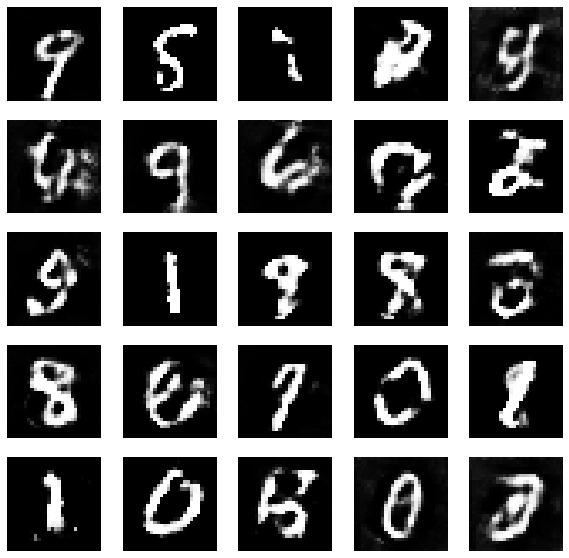

4500 [D loss: 0.439255, acc.: 82.81%] [G loss: 1.878366]


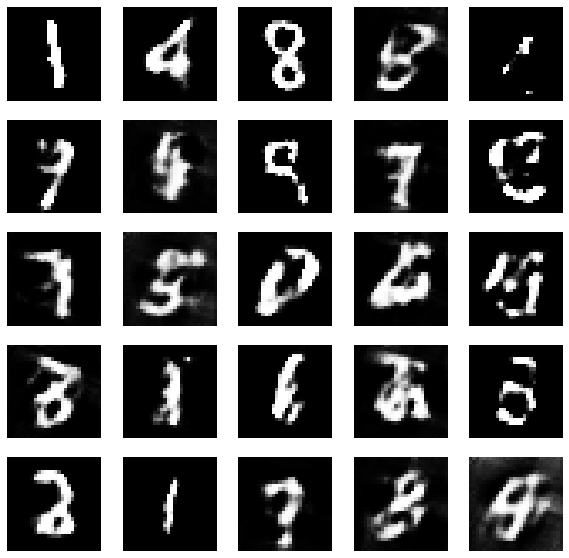

5000 [D loss: 0.483138, acc.: 80.47%] [G loss: 1.743036]


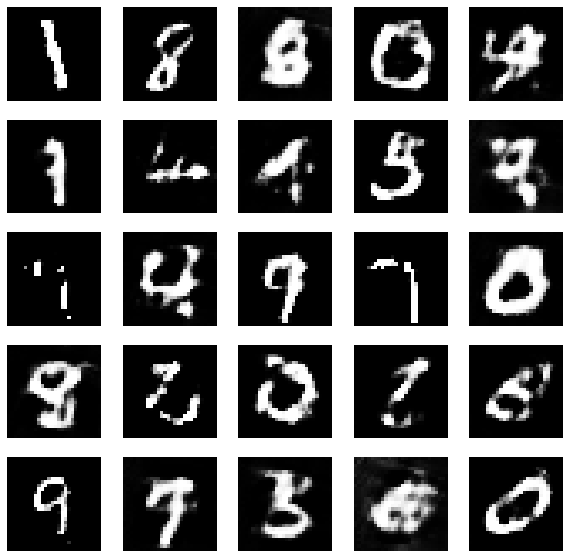

5500 [D loss: 0.470192, acc.: 79.69%] [G loss: 1.643358]


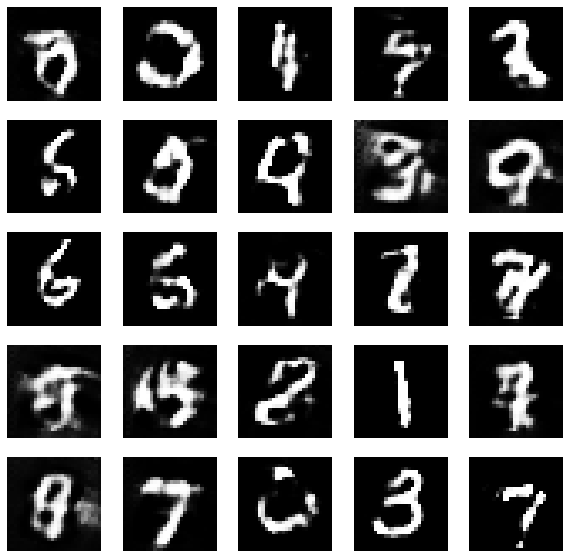

5999 [D loss: 0.481044, acc.: 77.34%] [G loss: 1.914427]


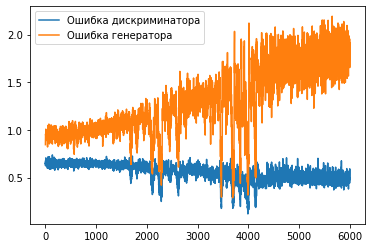

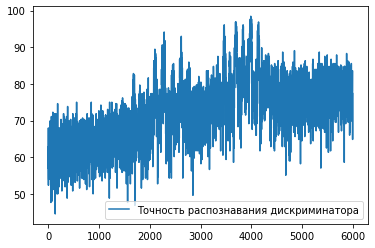

In [ ]:
GAN_algoritm (conv_gen,conv_disc,6000,batch_size=256,batch_size_d=128,DiskrTrainOnEpoch=1) 

Разные batch size для генератора и дискриминатора. обучение дискриминатора 5 шагов внутри каждого шага генератора

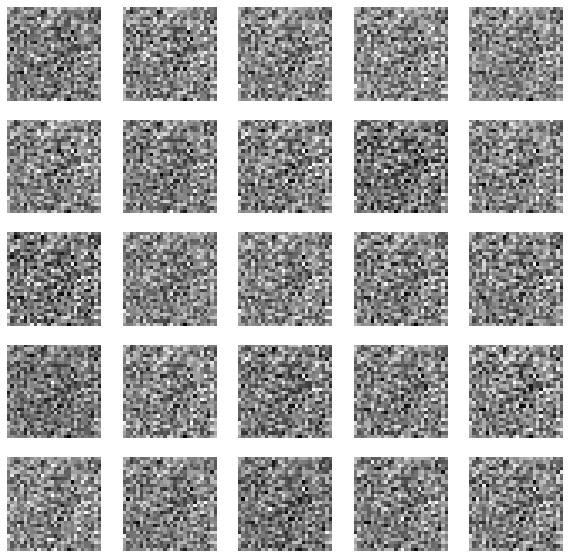

0 [D loss: 0.318922, acc.: 100.00%] [G loss: 0.472152]


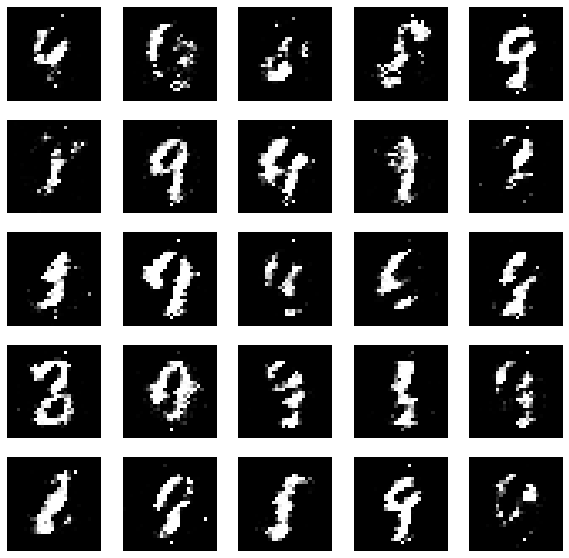

500 [D loss: 0.216181, acc.: 91.02%] [G loss: 2.195584]


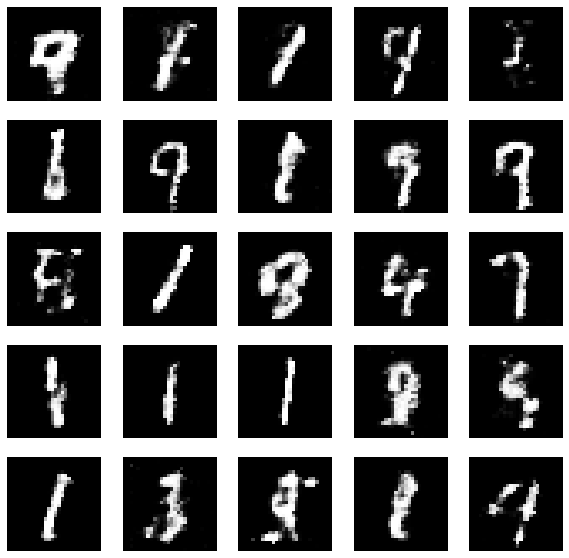

1000 [D loss: 0.242602, acc.: 87.89%] [G loss: 2.939173]


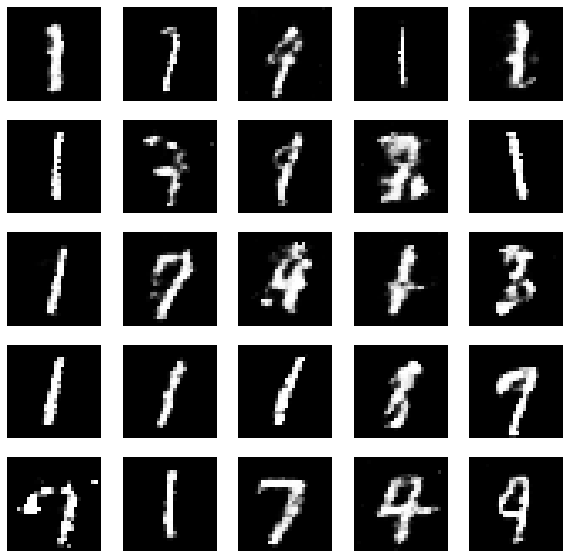

1500 [D loss: 0.251283, acc.: 90.23%] [G loss: 2.724661]


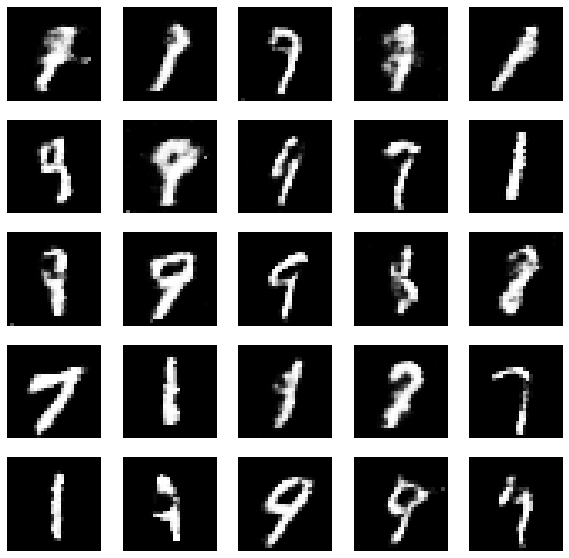

2000 [D loss: 0.267665, acc.: 90.23%] [G loss: 2.605596]


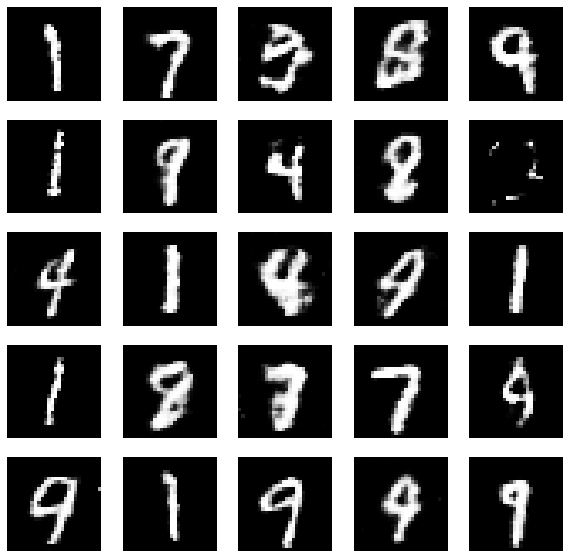

2500 [D loss: 0.379333, acc.: 82.81%] [G loss: 2.335792]


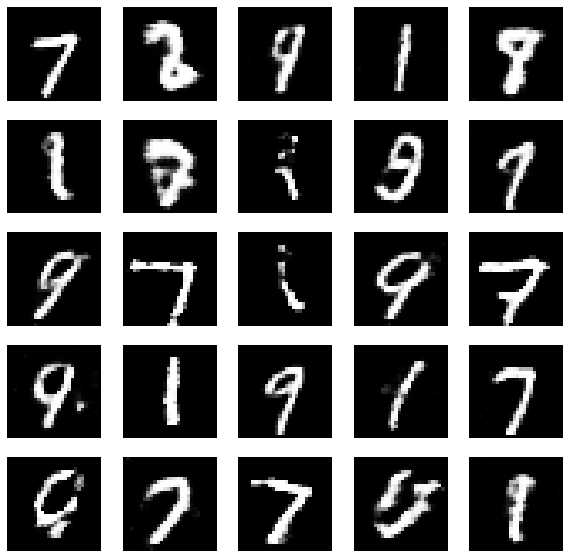

2999 [D loss: 0.396530, acc.: 80.08%] [G loss: 2.394556]


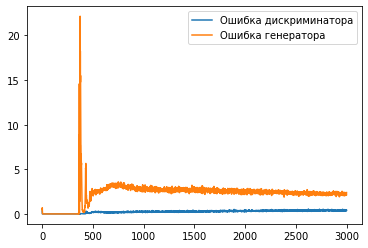

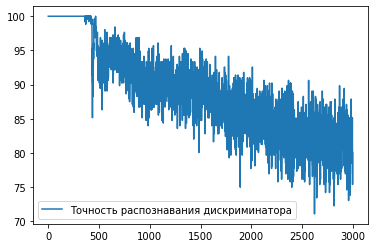

In [ ]:
GAN_algoritm (conv_gen,conv_disc,3000,batch_size=2048,batch_size_d=128,DiskrTrainOnEpoch=5) 

Изображения сверточного отличаются от изображений полносвязного. Сверточный не генерирует разбросанные пиксели. Сгенерированые изображения больше похожи на нарисованные ручкой.

Получилось что если batch size дискриминатора меньше чем у генаратора, дискриминатор учится быстрее. Точности 67,77 против 49, 75. Ожидалось наоборот с чем связанно не понятно. 

Имеет смысл задавать разные режимы обучения для генератора и дискриминатора чтобы уравновесить темп обучения. В последнем примере за один шаг обучения генератора на batch size=2048 выполнялось 5 шагов обучения дискриминатора с batch size=128. Если поэксперементировать с режимами обучения можо получить лучшие результаты.